#Lab 3 Exercises for COMP 691 (Deep Learning)

In this lab we will go over over basic stochastic optimization and how to use it in PyTorch.
- You will use the neural network you setup in lab 2 Exercise 2.
- Learn about parameter initialization.
- Learn about cross entropy loss.
- Train the neural network using mini-batch SGD w/o momentum. 

Start by making a **copy** of this notebook in your Google Colab.


A good source for understanding leaf tensors is [here](https://stackoverflow.com/questions/65301875/how-to-understand-creating-leaf-tensors-in-pytorch).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Exercise 1: Loading the dataset

Setup the MNIST dataloaders for both the training (as well test) set as in Lab 2, Exercise 1. You do not need to iterate through the dataloaders, these will be used in the rest of the lab. 


In [2]:
# This cell does not require outputing anything but is setup for subsequent cells
from torchvision import datasets,transforms
import torch
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
dataset2 = datasets.MNIST('../data', train=False, download=True, transform=transforms.ToTensor())

    


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



## Exercise 2: Setting up the neural network

Consider your work from Lab 2, Exercise 2. Modify the neural network as follows. 
- The hidden outputs should have size 100 in both hidden layers and the activations should be `relu`. 
- Modify the final layer to output 10 values instead of 1. This means that instead of having a single scalar value, you will have 10 output classes!

Your code should implement 

$$f(x) = W_2\rho(W_1\rho(W_0x+b_0)+b_1)+b_2$$

with $f: R^{786}-> R^{10}$ and $\rho = $ `relu`

**Initialize** the weights  using a variant of xavier intialization 

$$w_{ij} \sim \text{N}\left(0,\frac{1}{\sqrt{n_i}}\right)$$

where $n_i$ is the size of the layer input. Initialize the biases as 0. 

**Write** a helper function to perform this initialization for subsequent parts of this lab.

In [3]:
import torch

# set your target device
device='cuda'

## Initialize and track the parameters using a list or dictionary
param_dict = {
    "W0": (torch.rand((28*28, 100)) * 2 - 1).to(device),
    "b0": (torch.zeros(100)).to(device),
    "W1": (torch.rand((100, 100)) * 2 - 1).to(device),
    "b1": (torch.zeros(100)).to(device),
    "W2": (torch.rand((100, 10)) * 2 - 1).to(device),
    "b2": (torch.zeros(10)).to(device),
    }

## Make sure your parameters in param_dict are on the chosen device and that they require gradient for training the network later! 
for key in param_dict:
  param_dict[key].requires_grad=True

## Define the network
def my_nn(input, param_dict):
    """Performs a single forward pass of a Neural Network with the given 
    parameters in param_dict.

    Args:
        input (torch.tensor): Batch of images of shape (B, H, W), where B is 
            the number of input samples,and H and W are the image height and 
            width respectively.
        param_dict (dict of torch.tensor): Dictionary containing the parameters
            of the neural network. Expects dictionary keys to be of format 
            "W#" and "b#" where # is the layer number.

    Returns:
        torch.tensor: Neural network output of shape (B, )
    """
    x = input.view(-1, 28*28) 
    x = torch.matmul(x, param_dict['W0']) + param_dict['b0']
    x = torch.relu(x)
    x = torch.matmul(x, param_dict['W1']) + param_dict['b1']
    x = torch.relu(x)
    x = torch.matmul(x, param_dict['W2']) + param_dict['b2']

    return x


def initialize_nn(param_dict):
  """Takes a dictionary with existing torch tensors 
      and re-initializes them using xavier initialization
  """

  # make sure that your parameters are on the chosen device and that they require gradients!
  for name, param in param_dict.items():
        if name[0] == "W":
            in_features = param.shape[0]
            out_features = param.shape[1]
            param.data = torch.randn(in_features, out_features, device=device) / (in_features ** 0.5)
        elif name[0] == "b":
            param.data = torch.zeros(param.shape[0], device=device)
        else:
            raise ValueError(f"Parameter name {name} is not valid")
        param.requires_grad = True

initialize_nn(param_dict)


Now, we will evaluate the cross entropy loss and average accuracy on this randomly initialized dataset. 

Use the `torch.nn.functional.cross_entropy()` function to compute the loss $\frac{1}{N}\sum_i^N \text{CrossEntropy}(f(x_i),y_i)$ and accuracy.

Your accuracy should be close to $10\%$ as the network has random weights and no training has happened yet!

In [4]:
cuda = torch.cuda.is_available()

test_loader = torch.utils.data.DataLoader(dataset2,
                                          batch_size=100,
                                          shuffle=False)
test_loss = 0
test_acc = 0
for data, targets in test_loader:
  #move to GPU if available
  if cuda:
    data, targets = data.to('cuda'), targets.to('cuda')

  #compute model output
  out = my_nn(data, param_dict)

  #comptue accuracy for minibatch
  _, prediction = torch.max(out, dim=1)
  acc = (prediction == targets).sum() / targets.size(0)
  test_acc += acc.item()

  #compute loss for minibatch
  loss = torch.nn.functional.cross_entropy(out, targets)
  test_loss += loss.item()

#aggregate loss and accuracy for all test data
test_loss /= len(test_loader)
test_acc /= len(test_loader)

print(f"Test average loss: {test_loss:.4f}")
print(f"Test average accuracy: {test_acc * 100:.1f}%")

  

Test average loss: 2.2976
Test average accuracy: 11.3%


## Exercise 3: Training using mini-batch SGD from scratch

Without using the `torch.optim` package implement from scratch mini-batch Stochastic Gradient Descent training to minimize the loss  $\frac{1}{N}\sum_i^N \text{CrossEntropy}(f(x_i),y_i)$ over the MNIST dataset. 

- Use a minibatch size of 128 and a learning rate of 0.01. Run the training for 20 epochs.

- You will PyTorch's autograd features (e.g. `.backward()`) to obtain the gradients given each mini-batch at each parameter. Modify the existing parameters based on the obtained gradient using the SGD update rule, e.g. $w = w - \alpha * \frac{\partial loss}{\partial w}$.

- Store the losses and training of each minibatch and plot each of these (with iterations (not epochs) as the $x$-axis). You can optionally smooth out these plots over 20-100 iteration window of your choosing to make them cleaner to read. 

- Compute and report the final test accuracy as well at the end of the 20 epochs. 


You should end up with 2 plots and a final test accuracy that looks something like this

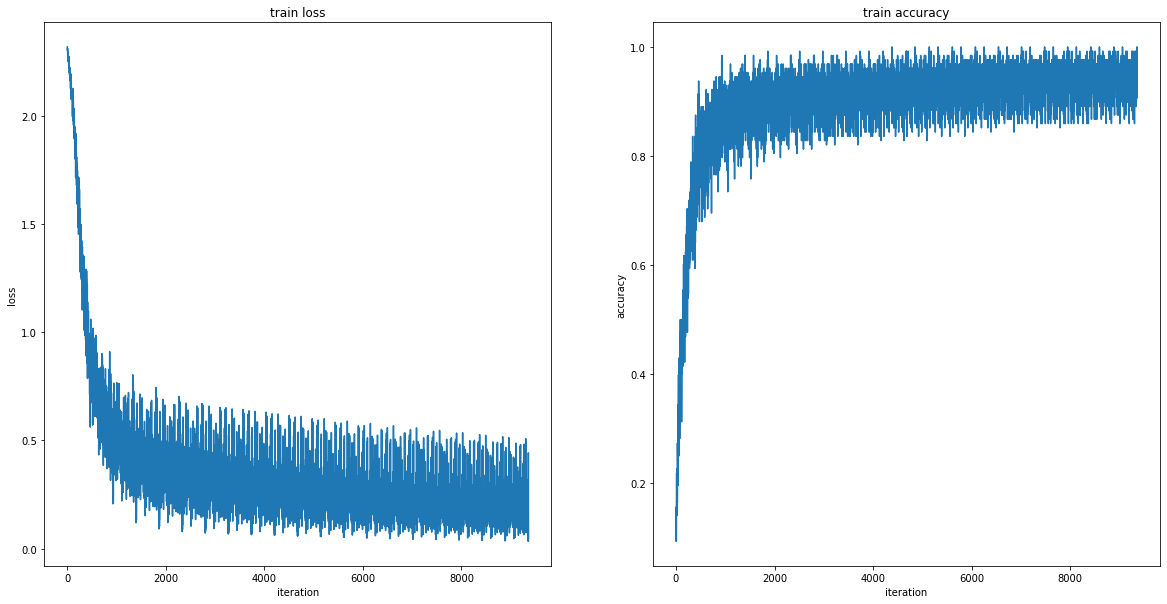


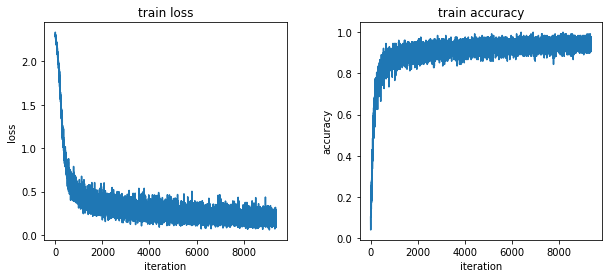

Test average accuracy: 94.5%


In [24]:
import torch
import matplotlib.pyplot as plt

train_loader = torch.utils.data.DataLoader(dataset1, 
                                           batch_size=128, 
                                           shuffle=True,
                                           drop_last=True)

train_losses = [] # use to append the avg loss for each minibatch 
train_accs = [] # use to append the avg acc of minibatch

alpha=0.01

initialize_nn(param_dict)
for epoch in range(20):
  for data, targets in train_loader: #Iterate over dataset
    if cuda:
      data, targets = data.to('cuda'), targets.to('cuda')
    #Compute the gradient for the minibatch
    out = my_nn(data, param_dict)
    loss = torch.nn.functional.cross_entropy(out, targets)
    loss.backward()
    
    for (_,param) in param_dict.items():
      with torch.no_grad():
        #Update the model parameters by w_t-alpha*grad
        param.data -= alpha * param.grad.data

      if param.grad is not None: 
        #The following code will clear the gradient buffers for the next iteration
        param.grad.detach_() 
        param.grad.zero_()
    
    #Update loss and acc tracking 
    train_losses.append(loss.item())
    train_accs.append((out.argmax(dim=1) == targets).float().mean().item())

#Plot the train loss and acc
fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].plot(train_losses)
axs[0].set_title('train loss')
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')

axs[1].plot(train_accs)
axs[1].set_title('train accuracy')
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('accuracy')

fig.subplots_adjust(wspace=0.3)
plt.show()

#Evaluate on the test set
test_acc = 0
for data, targets in test_loader:
    if cuda:
        data, targets = data.to('cuda'), targets.to('cuda')
    out = my_nn(data, param_dict)
    test_acc += (out.argmax(dim=1) == targets).float().mean().item()
test_acc = test_acc / len(test_loader)
print(f"Test average accuracy: {test_acc * 100:.1f}%")


## Exercise 4: Training using the pre-built torch.optim.SGD

Repeat Exercise 3 but now using the package `torch.optim.SGD` to perform SGD: 


https://pytorch.org/docs/stable/optim.html?highlight=torch%20optim%20sgd#torch.optim.SGD


Plot the same training curves and accuracy curves. Check that your learning curves are similar to those in Exercise 3. You can for example overlay them or plot them side by side with subplot.

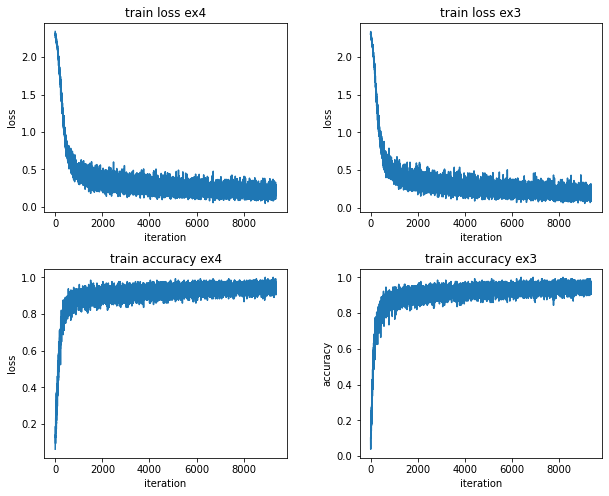

In [26]:
#Answer for SGD
import torch
#Make sure to reinitialize your network to random before starting training
initialize_nn(param_dict)

#optim.SGD takes a list of parameters which you can get from your dictionary as follows
parameter_list = param_dict.values()

optimizer = torch.optim.SGD(parameter_list, lr=alpha)

train_losses_ex4 = []
train_accs_ex4 = []
for epoch in range(20):
  # Loop over the training data in mini-batches
  for data, targets in train_loader:
    
    if cuda:
      data, targets = data.to('cuda'), targets.to('cuda')

    optimizer.zero_grad()
    out = my_nn(data, param_dict)
    loss = torch.nn.functional.cross_entropy(out, targets)

    loss.backward()
    optimizer.step()

      #Update loss and acc tracking 
    train_losses_ex4.append(loss.item())
    train_accs_ex4.append((out.argmax(dim=1) == targets).float().mean().item())

#Plot the train loss and acc
fig, axs = plt.subplots(2, 2, figsize=(10,8))

axs[0,0].plot(train_losses_ex4)
axs[0,0].set_title('train loss ex4')
axs[0,0].set_xlabel('iteration')
axs[0,0].set_ylabel('loss')
axs[0,1].plot(train_losses)
axs[0,1].set_title('train loss ex3')
axs[0,1].set_xlabel('iteration')
axs[0,1].set_ylabel('loss')

axs[1,0].plot(train_accs_ex4)
axs[1,0].set_title('train accuracy ex4')
axs[1,0].set_xlabel('iteration')
axs[1,0].set_ylabel('loss')
axs[1,1].plot(train_accs)
axs[1,1].set_title('train accuracy ex3')
axs[1,1].set_xlabel('iteration')
axs[1,1].set_ylabel('accuracy')

fig.subplots_adjust(wspace=0.3)
fig.subplots_adjust(hspace=0.3)
plt.show()


## Optional: Training using mini-batch SGD with momentum

Modify the code from Exercises 3 and 4 to perform minibatch SGD with momentum. Use a momentum of $\mu=0.9$ and learning rate $\alpha=0.01$. Use the following formulation of momentum: 

- $g = \nabla_wCE(f(w_t,X),Y)$: gradient estimate with mini-batch
- $v_{t+1} = \mu * v_t + g$ 
- $w_{t+1} = w - \alpha*v_{t+1}$ 

Obtain the same plots as before and a final test accuracy.

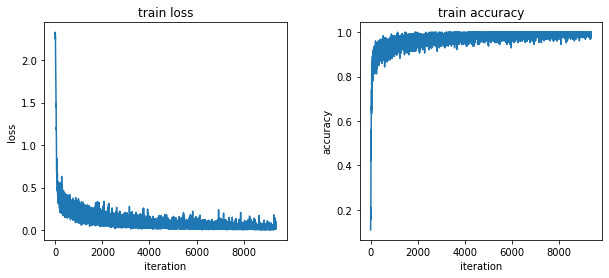

Test average accuracy: 97.7%


In [28]:
# Reinitialize your network to random!
initialize_nn(param_dict)

train_losses = [] # use to append the avg loss for each minibatch 
train_accs = [] # use to append the avg acc of minibatch

alpha=0.01
mu=0.9
v = {key: torch.zeros_like(param) for key, param in param_dict.items()}
for epoch in range(20):
  for data, targets in train_loader: #Iterate over dataset
    if cuda:
      data, targets = data.to('cuda'), targets.to('cuda')
    #Compute the gradient for the minibatch
    out = my_nn(data, param_dict)
    loss = torch.nn.functional.cross_entropy(out, targets)
    loss.backward()
    
    for (key, param) in param_dict.items():
      with torch.no_grad():
        #Update the model parameters by w_t-alpha*grad
        v[key] = mu * v[key] + param.grad.data
        param.data -= alpha * v[key]

      if param.grad is not None: 
        #The following code will clear the gradient buffers for the next iteration
        param.grad.detach_() 
        param.grad.zero_()
    
    #Update loss and acc tracking 
    train_losses.append(loss.item())
    train_accs.append((out.argmax(dim=1) == targets).float().mean().item())

#Plot the train loss and acc
fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].plot(train_losses)
axs[0].set_title('train loss')
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')

axs[1].plot(train_accs)
axs[1].set_title('train accuracy')
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('accuracy')

fig.subplots_adjust(wspace=0.3)
plt.show()

#Evaluate on the test set
test_acc = 0
for data, targets in test_loader:
    if cuda:
        data, targets = data.to('cuda'), targets.to('cuda')
    out = my_nn(data, param_dict)
    test_acc += (out.argmax(dim=1) == targets).float().mean().item()
test_acc = test_acc / len(test_loader)
print(f"Test average accuracy: {test_acc * 100:.1f}%")


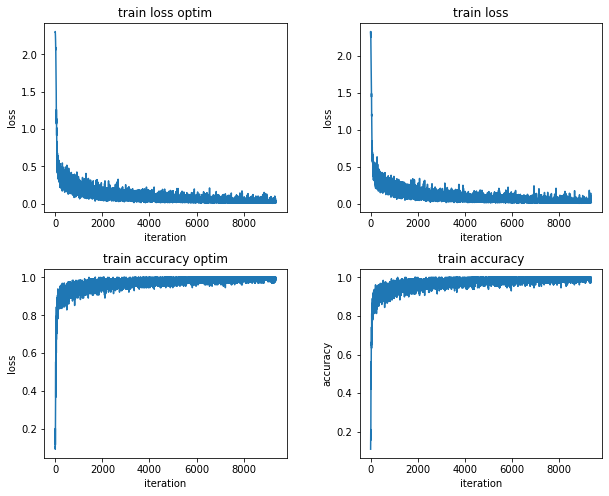

Test average accuracy: 97.6%


In [29]:
# Answer for SGD+momentum
import torch
#Make sure to reinitialize your network to random before starting training
initialize_nn(param_dict)

#optim.SGD takes a list of parameters which you can get from your dictionary as follows
parameter_list = param_dict.values()

optimizer = torch.optim.SGD(parameter_list, lr=alpha, momentum=mu)

train_losses_op = []
train_accs_op = []
for epoch in range(20):
  # Loop over the training data in mini-batches
  for data, targets in train_loader:
    
    if cuda:
      data, targets = data.to('cuda'), targets.to('cuda')

    optimizer.zero_grad()
    out = my_nn(data, param_dict)
    loss = torch.nn.functional.cross_entropy(out, targets)

    loss.backward()
    optimizer.step()

      #Update loss and acc tracking 
    train_losses_op.append(loss.item())
    train_accs_op.append((out.argmax(dim=1) == targets).float().mean().item())

#Plot the train loss and acc
fig, axs = plt.subplots(2, 2, figsize=(10,8))

axs[0,0].plot(train_losses_op)
axs[0,0].set_title('train loss optim')
axs[0,0].set_xlabel('iteration')
axs[0,0].set_ylabel('loss')
axs[0,1].plot(train_losses)
axs[0,1].set_title('train loss')
axs[0,1].set_xlabel('iteration')
axs[0,1].set_ylabel('loss')

axs[1,0].plot(train_accs_op)
axs[1,0].set_title('train accuracy optim')
axs[1,0].set_xlabel('iteration')
axs[1,0].set_ylabel('loss')
axs[1,1].plot(train_accs)
axs[1,1].set_title('train accuracy')
axs[1,1].set_xlabel('iteration')
axs[1,1].set_ylabel('accuracy')

fig.subplots_adjust(wspace=0.3)
fig.subplots_adjust(hspace=0.3)
plt.show()

#Evaluate on the test set
test_acc = 0
for data, targets in test_loader:
    if cuda:
        data, targets = data.to('cuda'), targets.to('cuda')
    out = my_nn(data, param_dict)
    test_acc += (out.argmax(dim=1) == targets).float().mean().item()
test_acc = test_acc / len(test_loader)
print(f"Test average accuracy: {test_acc * 100:.1f}%")